In [10]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 컨텍스트 오프로딩: 파일 시스템

<img src="./assets/agent_header_files.png" width="800" style="display:block; margin-left:0;">

복잡한 작업 중에는 에이전트 컨텍스트 창이 빠르게 커질 수 있습니다. 일반적인 Manus 작업은 약 50개의 도구 호출을 사용하며, 상당한 컨텍스트 누적을 초래합니다. 이러한 증가를 관리하는 강력한 기술은 파일 시스템 작업을 통한 **컨텍스트 오프로딩**입니다. 모든 도구 호출 관찰 및 중간 결과를 컨텍스트 창에 직접 저장하는 대신, 에이전트는 정보를 파일에 전략적으로 저장하고 [필요에 따라 가져와](https://blog.langchain.com/context-engineering-for-agents/) 중요한 정보에 대한 액세스를 유지하면서 초점을 유지할 수 있습니다.

이러한 접근 방식은 [Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus) 및 [Hugging Face Open Deep Research](https://huggingface.co/blog/open-deep-research)와 같은 프로덕션 시스템에서 성공적으로 구현되었습니다. Anthropic의 [다중 에이전트 연구 시스템](https://www.anthropic.com/engineering/multi-agent-research-system#:~:text=Subagent%20output%20to%20a%20filesystem%20to%20minimize%20the%20%E2%80%98game%20of%20telephone.%E2%80%99)은 하위 에이전트가 외부 시스템에 작업을 저장하고 코디네이터에게 경량 참조를 다시 전달하는 또 다른 설득력 있는 예시를 제공합니다. 이는 정보가 여러 에이전트를 통과할 때 발생하는 "전화 놀이" 효과(정보 저하)를 방지하는 동시에 새로운 하위 에이전트가 깨끗한 컨텍스트로 생성되고 필요할 때 메모리에서 연구 계획과 같은 저장된 컨텍스트를 검색할 수 있도록 합니다.

샌드박스 환경에서 토큰이 많은 컨텍스트를 파일에 작성함으로써 에이전트는 필요한 경우 상세 정보를 검색할 수 있는 기능을 유지하면서 메모리를 효과적으로 관리할 수 있습니다. 이 패턴은 코드, 보고서 또는 데이터 시각화와 같이 전문화된 프롬프트가 일반 코디네이터를 통해 필터링하는 것보다 더 나은 결과를 생성하는 구조화된 출력과, 중간 결과를 지속적인 주의 없이 보존해야 하는 장기 실행 연구 작업에 특히 유용합니다.

### 파일 도구

우리 구현은 LangGraph 상태 내에서 전통적인 파일 시스템을 모의하는 가상 파일 시스템 접근 방식을 사용합니다. 핵심 통찰력은 키가 모의 파일 경로를 나타내고 값이 파일 내용을 포함하는 간단한 사전을 사용하는 것입니다. 이 접근 방식은 단일 에이전트 대화 내에서 컨텍스트를 유지하는 데 이상적인 단기, 스레드별 지속성을 제공하지만, 다른 대화 스레드 간에 지속되어야 하는 정보에는 적합하지 않습니다. 파일 작업은 LangGraph의 `Command` 유형을 활용하여 에이전트 상태를 업데이트하고, 도구가 가상 파일 시스템을 수정하고 에이전트 실행 전반에 걸쳐 적절한 상태 관리를 유지할 수 있도록 합니다.

가상 파일 시스템에서 작동하는 세 가지 파일 도구(`ls`, `read_file`, `write_file`)를 구축할 것입니다.

**사용법:**
- LLM이 유지하려는 컨텍스트에 정보가 있으면 `write_file()`을 사용하여 파일에 기록합니다. 나중에 동일한 에이전트 또는 하위 에이전트가 `read_file()`을 사용하여 검색할 수 있습니다.
- 도구 호출은 파일에 데이터를 기록하고 도구 호출 반환 메시지에 파일 이름을 LLM에 제공할 수 있습니다. LLM은 나중에 내용의 일부 또는 전부를 읽거나 다른 도구를 적용하여 데이터를 처리할 수 있습니다.
- `ls`를 사용하여 사용 가능한 파일을 나열합니다.

읽기/쓰기 도구는 줄 바꿈으로 구분된 일반 텍스트(`str.splitlines()`로 구문 분석됨)를 예상합니다.

아래 프롬프트의 설명은 작동 방식을 자세히 설명합니다:

In [11]:
from utils import show_prompt

from deep_agents_from_scratch.prompts import (
    LS_DESCRIPTION,
    READ_FILE_DESCRIPTION,
    WRITE_FILE_DESCRIPTION,
)

show_prompt(LS_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  List all files in the virtual filesystem stored in agent state.                                                │
│                                                                                                                 │
│  Shows what files currently exist in agent memory. Use this to orient yourself before other file operations     │
│  and maintain awareness of your file organization.                                                              │
│                                                                                                                 │
│  No parameters required - simply call ls() to see all available files.                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [12]:
show_prompt(READ_FILE_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Read content from a file in the virtual filesystem with optional pagination.                                   │
│                                                                                                                 │
│  This tool returns file content with line numbers (like `cat -n`) and supports reading large files in chunks    │
│  to avoid context overflow.                                                                                     │
│                                                                                                                 │
│  Parameters:                                                                                                    │
│  - file_path (required): Path to the file you want to read                                                      │
│  - offset (optional, default=0): Line number to start reading from                                              │
│  - limit (optional, default=2000): Maximum number of lines to read                                              │
│                                                                                                                 │
│  Essential before making any edits to understand existing content. Always read a file before editing it.        │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [13]:
show_prompt(WRITE_FILE_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Create a new file or completely overwrite an existing file in the virtual filesystem.                          │
│                                                                                                                 │
│  This tool creates new files or replaces entire file contents. Use for initial file creation or complete        │
│  rewrites. Files are stored persistently in agent state.                                                        │
│                                                                                                                 │
│  Parameters:                                                                                                    │
│  - file_path (required): Path where the file should be created/overwritten                                      │
│  - content (required): The complete content to write to the file                                                │
│                                                                                                                 │
│  Important: This replaces the entire file content.                                                              │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

아래에서 이러한 함수를 구현해 보겠습니다. 주목할 만한 두 가지 사항이 있습니다. 첫 번째는 `@tool(description=PROMPT)`의 사용입니다. `description="xyz"`가 도구 데코레이터에 있으면 "xyz"가 LLM에 전송되고 독스트링은 억제됩니다. 별도의 프롬프트 파일에 긴 설명을 두는 것이 더 편리한 경우가 많습니다. 이는 도구의 작동 방식과 이 애플리케이션에서 사용해야 하는 방법을 모두 설명할 수 있는 공간을 제공합니다. 두 번째 항목은 오류 메시지입니다. 이 메시지는 인간 사용자보다는 LLM을 위한 것입니다. 에이전트 시스템에서 LLM은 오류 메시지의 정보를 사용하여 작업을 재시도할 수 있습니다.

In [14]:
%%writefile ../src/deep_agents_from_scratch/file_tools.py
"""Virtual file system tools for agent state management.

This module provides tools for managing a virtual filesystem stored in agent state,
enabling context offloading and information persistence across agent interactions.
"""

from typing import Annotated

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command

from deep_agents_from_scratch.prompts import (
    LS_DESCRIPTION,
    READ_FILE_DESCRIPTION,
    WRITE_FILE_DESCRIPTION,
)
from deep_agents_from_scratch.state import DeepAgentState


@tool(description=LS_DESCRIPTION)
def ls(state: Annotated[DeepAgentState, InjectedState]) -> list[str]:
    """List all files in the virtual filesystem."""
    return list(state.get("files", {}).keys())


@tool(description=READ_FILE_DESCRIPTION, parse_docstring=True)
def read_file(
    file_path: str,
    state: Annotated[DeepAgentState, InjectedState],
    offset: int = 0,
    limit: int = 2000,
) -> str:
    """Read file content from virtual filesystem with optional offset and limit.

    Args:
        file_path: Path to the file to read
        state: Agent state containing virtual filesystem (injected in tool node)
        offset: Line number to start reading from (default: 0)
        limit: Maximum number of lines to read (default: 2000)

    Returns:
        Formatted file content with line numbers, or error message if file not found
    """
    files = state.get("files", {})
    if file_path not in files:
        return f"Error: File '{file_path}' not found"

    content = files[file_path]
    if not content:
        return "System reminder: File exists but has empty contents"

    lines = content.splitlines()
    start_idx = offset
    end_idx = min(start_idx + limit, len(lines))

    if start_idx >= len(lines):
        return f"Error: Line offset {offset} exceeds file length ({len(lines)} lines)"

    result_lines = []
    for i in range(start_idx, end_idx):
        line_content = lines[i][:2000]  # Truncate long lines
        result_lines.append(f"{i + 1:6d}\t{line_content}")

    return "\n".join(result_lines)


@tool(description=WRITE_FILE_DESCRIPTION, parse_docstring=True)
def write_file(
    file_path: str,
    content: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> Command:
    """Write content to a file in the virtual filesystem.

    Args:
        file_path: Path where the file should be created/updated
        content: Content to write to the file
        state: Agent state containing virtual filesystem (injected in tool node)
        tool_call_id: Tool call identifier for message response (injected in tool node)

    Returns:
        Command to update agent state with new file content
    """
    files = state.get("files", {})
    files[file_path] = content
    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(f"Updated file {file_path}", tool_call_id=tool_call_id)
            ],
        }
    )

Overwriting ../src/deep_agents_from_scratch/file_tools.py


# 상태 및 리듀서 다시 살펴보기

이전 노트북에서 파일 상태 및 리듀서를 정의했지만, 여기서는 설명하지 않았습니다. 여기에서 설명해 보겠습니다.
`DeepAgentState`에서 `files`는 키와 값을 가진 사전으로 정의됩니다. 위에서 언급했듯이 키는 파일 이름이고 값은 파일의 내용입니다. `files`는 `write_files`의 `Command`가 실행될 때 `file_reducer`를 사용하여 상태에 추가됩니다. 이 리듀서에서 `left`는 상태의 기존 파일이고 `right`는 새 값입니다. 최종 문은 새 값이 이전 값을 덮어쓰도록 합니다: `{**left, **right}`. Python은 `left`를 먼저 압축 해제한 다음 `right`를 압축 해제합니다. `right`의 중복 키는 `left`의 이전 값을 덮어씁니다.

```python
def file_reducer(left, right):
    """두 파일 사전을 병합하되, 오른쪽이 우선권을 가집니다.

    에이전트 상태의 파일 필드에 대한 리듀서 함수로 사용되며,
    가상 파일 시스템에 대한 증분 업데이트를 허용합니다.

    인수:
        left: 왼쪽 사전(기존 파일)
        right: 오른쪽 사전(새/업데이트된 파일)

    반환:
        오른쪽 값이 왼쪽 값을 덮어쓴 병합된 사전
    """
    if left is None:
        return right
    elif right is None:
        return left
    else:
        return {**left, **right}


class DeepAgentState(AgentState):
    """작업 추적 및 가상 파일 시스템을 포함하는 확장된 에이전트 상태입니다.

    LangGraph의 AgentState를 상속하고 다음을 추가합니다.
    - todos: 작업 계획 및 진행 상황 추적을 위한 Todo 항목 목록
    - files: 파일 이름을 내용에 매핑하는 사전으로 저장된 가상 파일 시스템
    """

    todos: NotRequired[list[Todo]]
    files: Annotated[NotRequired[dict[str, str]], file_reducer]
```

가상 파일 시스템과 이를 다루는 도구가 있습니다. 이제 간단한 연구 에이전트를 구축하여 시도해 봅시다.
에이전트는 사용자 요청을 저장한 다음 사용자 질문에 답하기 전에 다시 읽을 것입니다!

이 간단한 접근 방식은 [장기 실행 에이전트 궤적에 매우 유용합니다](https://www.anthropic.com/engineering/multi-agent-research-system#:~:text=Long%2Dhorizon%20conversation,across%20extended%20interactions.)! 이 간단한 예제에서는 모든 정보를 컨텍스트에 쉽게 보관할 수 있지만, 장기 실행 에이전트의 경우 컨텍스트 내용을 압축하거나 제거할 수 있습니다. 압축 전에 정보를 저장하고 필요할 때 검색하는 것은 현명한 컨텍스트 엔지니어링입니다.

In [15]:
# File usage instructions
FILE_USAGE_INSTRUCTIONS = """You have access to a virtual file system to help you retain and save context.                                  
                                                                                                                
## Workflow Process                                                                                            
1. **Orient**: Use ls() to see existing files before starting work                                             
2. **Save**: Use write_file() to store the user's request so that we can keep it for later                     
3. **Read**: Once you are satisfied with the collected sources, read the saved file and use it to ensure that you directly answer the user's question."""

# Add mock research instructions
SIMPLE_RESEARCH_INSTRUCTIONS = """IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the user's question."""

# Full prompt
INSTRUCTIONS = (
    FILE_USAGE_INSTRUCTIONS + "\n\n" + "=" * 80 + "\n\n" + SIMPLE_RESEARCH_INSTRUCTIONS
)
show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You have access to a virtual file system to help you retain and save context.                                  │
│                                                                                                                 │
│  ## Workflow Process                                                                                            │
│  1. **Orient**: Use ls() to see existing files before starting work                                             │
│  2. **Save**: Use write_file() to store the user's request so that we can keep it for later                     │
│  3. **Read**: Once you are satisfied with the collected sources, read the saved file and use it to ensure that  │
│  you directly answer the user's question.                                                                       │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer    │
│  the user's question.                                                                                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

E0000 00:00:1760675672.398133  539871 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


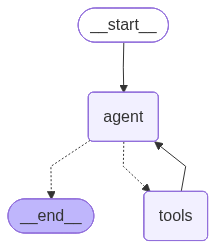

In [16]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from utils import format_messages

from deep_agents_from_scratch.file_tools import ls, read_file, write_file
from deep_agents_from_scratch.state import DeepAgentState

# Mock search result
search_result = """The Model Context Protocol (MCP) is an open standard protocol developed 
by Anthropic to enable seamless integration between AI models and external systems like 
tools, databases, and other services. It acts as a standardized communication layer, 
allowing AI models to access and utilize data from various sources in a consistent and 
efficient manner. Essentially, MCP simplifies the process of connecting AI assistants 
to external services by providing a unified language for data exchange. """


# Mock search tool
@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """Search the web for information on a specific topic.

    This tool performs web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.

    Args:
        query: The search query string. Be specific and clear about what
               information you're looking for.

    Returns:
        Search results from search engine.

    Example:
        web_search("machine learning applications in healthcare")
    """
    return search_result


# Create agent using create_react_agent directly
model = init_chat_model(model="google_genai:gemini-2.5-flash", temperature=0.0)
tools = [ls, read_file, write_file, web_search]

# Create agent with system prompt
agent = create_react_agent(
    model, tools, prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

상태에 `files`가 없고 사용자 연구 요청이 있는 그래프를 시작합니다.

In [17]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
        "files": {},
    }
)
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: web_search                                                                                        │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol (MCP) overview"                                                              │
│ }                                                                                                               │
│    ID: 81b26ee7-a41b-4109-a5d2-825092b2f792                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard protocol developed                                         │
│ by Anthropic to enable seamless integration between AI models and external systems like                         │
│ tools, databases, and other services. It acts as a standardized communication layer,                            │
│ allowing AI models to access and utilize data from various sources in a consistent and                          │
│ efficient manner. Essentially, MCP simplifies the process of connecting AI assistants                           │
│ to external services by providing a unified language for data exchange.                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard protocol created by Anthropic. Its purpose is to           │
│ facilitate smooth integration between AI models and external systems such as tools, databases, and other        │
│ services. MCP functions as a standardized communication layer, enabling AI models to access and use data from   │
│ diverse sources consistently and efficiently. In essence, it streamlines the connection of AI assistants to     │
│ external services by offering a unified language for data exchange.                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

우리 모의 파일 시스템에 저장된 파일을 확인할 수 있습니다. 

In [18]:
result["files"]

{}

Trace: 
https://smith.langchain.com/public/b03e20b4-e908-488d-84a9-8f891d17addd/r
<!-- https://smith.langchain.com/public/1066102f-d7b3-423c-b556-006865a1d479/r -->